In [222]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import expm
# Plotting
import matplotlib.pyplot as plt

# Setting of the main hyper-parameters of the model

In [223]:
n_qubits = 1  # Number of system qubits.
n_shots = 10 ** 6  # Number of quantum measurements.
phase_qubits = 4 # Number of qubits used for phase estimation.
ancilla_qubit = 1 # Number of ancillary qubits used for eigenvalue encoding amplitude
tot_qubits = n_qubits + phase_qubits + ancilla_qubit # Total number of qubits (system + ancillary + QPE qubits).
dim = 2 ** n_qubits  # Dimension of the problem space

In [224]:
# Assume phase_wires and target_wire are defined as in previous cells
phase_wires = range(phase_qubits)  # Phase estimation wires
target_wires = range(phase_qubits, phase_qubits + n_qubits)  # Target wires
ancilla_wires = range(phase_qubits + n_qubits, phase_qubits + n_qubits + ancilla_qubit)  # Ancilla wires

# HHL algorithms

## Unitary Gate of the problem matrix A: $e^{iA}$ 

In [225]:
def apply_unitary(wires):
    # Define Hermitian matrix A
    # A = np.array([
    #     [1, 0, 0, 1],
    #     [0, 2, 1, 0],
    #     [0, 1, 3, 0],
    #     [1, 0, 0, 4]
    # ], dtype=np.complex128)
    A = np.array([[-1.5, 0.5],
           [0.5, -1.5]], dtype=np.complex128)
    A = -np.array(A)
    # Compute the unitary U = exp(iA)
    U = expm(1j * A)
    # Confirm unitarity
    assert np.allclose(U.conj().T @ U, np.eye(2**n_qubits)), "U is not unitary"
    # Apply the unitary operation to the specified wires
    qml.QubitUnitary(U, wires=wires)
    

## QPE Circuit

In [226]:
# Define the quantum phase estimation circuit
def qpe_circuit(phase_wires, target_wire): 
    # Initialize target in eigenstate of U
    # qml.Hadamard(wires=target_wire)

    # Apply Hadamards to phase register
    for w in phase_wires:
        qml.Hadamard(wires=w)

    # Apply controlled-U^{2^k}
    apply_unitary_powers = [2 ** i for i in range(len(phase_wires))]

    for i, power in enumerate(apply_unitary_powers):
        for _ in range(power):
            qml.ctrl(apply_unitary, control=phase_wires[::-1][i])(wires=target_wire)

    # Apply inverse QFT
    qml.adjoint(qml.QFT)(wires=phase_wires)

## Control-Rotation gate for embedding inverse eigenvalues $\lambda_i \rightarrow \lambda_i^{-1}$

In [227]:
def AQE_fractional_rotation(control_wires, target_wire):
    """Apply controlled RY rotation based on fractional binary interpretation of control qubits."""
    n = len(control_wires)

    for d in range(1, 2**n):  # skip d=0 to avoid divide-by-zero
        # Convert decimal to binary string to run all possible state
        bin_str = f"{d:0{n}b}"
        # Convert binary string to list of bits for controlled rotation
        bit_strings = [int(bit) for bit in bin_str]
        # Compute fractional binary value: d = sum x_j * 2^-j
        fractional_d = sum(int(bit) * 2**-(j+1) for j, bit in enumerate(bin_str))
        # Compute the inverse of the fractional value
        inv = 1 / fractional_d
        # Normalize to [0, 1] range
        inv = inv / (2 ** n)
        # Convert to angle for RY gate, the state |0> amplitude corresponds to inv value
        theta = np.arccos(inv) * 2  # 2*theta for full RY
        # Apply controlled RY rotation on target wire controling on control wires
        qml.ctrl(qml.RY, control=control_wires, control_values=bit_strings)(theta,wires=target_wire)


## HHL Quantum circuit

In [ ]:
dev = qml.device("default.qubit", wires=tot_qubits)
@qml.qnode(dev)
def hhl_circuit():
    # 1. Initialize the target qubit
    # Normalize the input vector
    vector = np.array([0.03, -0.02])
    norm_vector = vector / np.linalg.norm(vector)
    print()
    # Initialize the quantum state to the normalized vector on the target wires
    qml.QubitStateVector(norm_vector, wires=target_wires)
    # for target_wire in target_wires:
    #     qml.Hadamard(wires=target_wire) # in this example, |b> = U_b |0> = H_0 H_1 ... |0>

    # 2. Apply QPE (Quantum Phase Estimation)
    qpe_circuit(phase_wires, target_wires)

    # 3. Apply AQE fractional rotation (controlled RY based on phase_wires)
    AQE_fractional_rotation(phase_wires, ancilla_wires)

    # 4. Apply inverse QPE (adjoint of QPE)
    qml.adjoint(qpe_circuit)(phase_wires, target_wires)

    # 5. Measure the target qubit
    probs = qml.probs(wires= [*target_wires,*ancilla_wires])
    
    return probs

## Run HHL algorithm

Target qubit probabilities: [0.03896674 0.63877567 0.00843368 0.31382391]


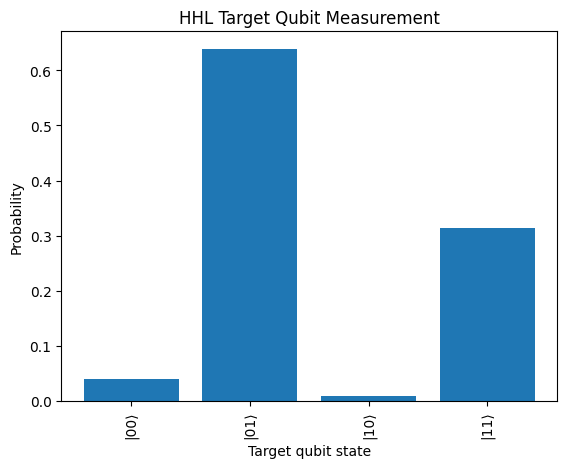

In [229]:
probs = hhl_circuit()
print("Target qubit probabilities:", probs)
# Plot the result
plt.bar([f"|{i:0{len(bin(len(probs)-1))-2}b}⟩" for i in range(len(probs))], probs)
plt.xticks(rotation=90)
plt.xlabel("Target qubit state")
plt.ylabel("Probability")
plt.title("HHL Target Qubit Measurement")
plt.show()

Retain only probabilities where the ancilla qubit (last qubit) is in state |0>

In [230]:
# Get indices where ancilla qubit is 0 (i.e., even indices)
ancil_position = tot_qubits - ancilla_wires[0] - 1  # Assuming ancilla_wires is a list with one element
ancilla_zero_indices = [i for i in range(len(probs)) if (i & 2**ancil_position) == 0]
probs_ancilla0 = probs[ancilla_zero_indices]
print("Probabilities of targer qubits with ancilla qubit in |0>:", probs_ancilla0)
# Normalize the filtered probabilities
probs_ancilla0_normalized = probs_ancilla0 / np.sum(probs_ancilla0)
print("Normalized probabilities:", probs_ancilla0_normalized)

Probabilities of targer qubits with ancilla qubit in |0>: [0.03896674 0.00843368]
Normalized probabilities: [0.8220759 0.1779241]


Target qubit probabilities: [0.8220759 0.1779241]


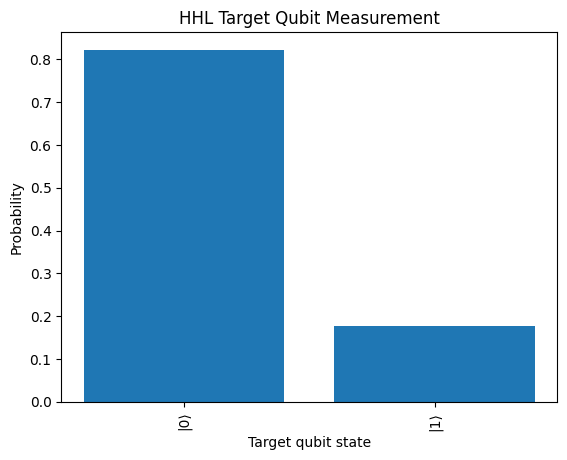

In [231]:
print("Target qubit probabilities:", probs_ancilla0_normalized)
# Plot the result
plt.bar([f"|{i:0{len(bin(len(probs_ancilla0_normalized)-1))-2}b}⟩" for i in range(len(probs_ancilla0_normalized))], probs_ancilla0_normalized)
plt.xticks(rotation=90)
plt.xlabel("Target qubit state")
plt.ylabel("Probability")
plt.title("HHL Target Qubit Measurement")
plt.show()

## QPE function from Pennylane

In [ ]:
def U(wires):
    return qml.RZ(2 * np.pi * 0.5, wires=wires) # qml.PhaseShift(2 * np.pi / 5, wires=wires)

dev = qml.device("default.qubit", wires=5)
@qml.qnode(dev)
# Another QPE function from Pennylane documentation
def circuit_qpe():
    estimation_wires = [0,1,2,3]
    target_wires = 4
    # initialize to state |1>
    # qml.PauliX(wires=4)

    for wire in estimation_wires:
        qml.Hadamard(wires=wire)

    qml.ControlledSequence(U(wires=target_wires), control=estimation_wires)

    qml.adjoint(qml.QFT)(wires=estimation_wires)

    return qml.probs(wires=estimation_wires)


In [ ]:
probs = circuit_qpe()
print(probs)

[9.49116908e-34 2.21670868e-33 6.19242684e-33 2.23830617e-32
 1.00000000e+00 2.84971388e-32 5.40420435e-33 1.37759139e-33
 2.08281348e-33 4.80826358e-34 8.69953014e-34 1.40801781e-33
 9.37349864e-34 2.44875649e-34 5.80786434e-34 7.06899438e-34]


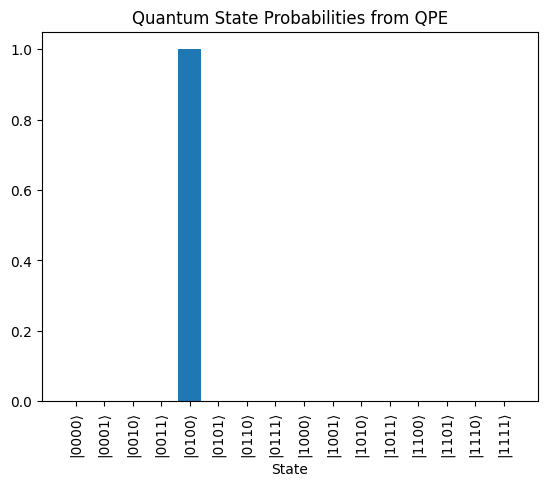

In [311]:
plt.bar([f"|{i:0{len(bin(len(probs)-1))-2}b}⟩" for i in range(len(probs))], probs)
plt.xticks(rotation=90)
plt.xlabel("State")
plt.title("Quantum State Probabilities from QPE")
plt.show()

The order of binary representation in Pennylane is like $\ket{001} = 1$, which is fliping the last qubit (3rd qubit). However, in the reverse binary rep., $\ket{001} = 2^{-3}$

# Comparison of quantum and classical results

## Classical algorithm

Generate the defined matrix A from example above

In [232]:
A_num = np.array([
        [1, 0, 0, 1],
        [0, 2, 1, 0],
        [0, 1, 3, 0],
        [1, 0, 0, 4]
    ], dtype=np.complex128)
b = np.ones(dim) / np.sqrt(dim)

In [233]:
A_num = np.array([[-1.5, 0.5],
           [0.5, -1.5]], dtype=np.complex128)
b = np.array([0.03, -0.02])

In [234]:
print("A = \n", A_num)
print("b = \n", b)

A = 
 [[-1.5+0.j  0.5+0.j]
 [ 0.5+0.j -1.5+0.j]]
b = 
 [ 0.03 -0.02]


Classical algorithm via np.linalg

In [235]:
# The solution can be computed via a matrix inversion:
A_num = -np.array(A_num)
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

In [ ]:
# In order to compare x with the quantum state |x>, we normalize and square its elements.
c_probs = (x / np.linalg.norm(x)) ** 2

## Comparison

In [238]:
# Classical result
print("x_n^2 =\n", c_probs)

x_n^2 =
 [0.84482759+0.j 0.15517241-0.j]


In [240]:
# Quantum result
print("|<x|n>|^2=\n", probs_ancilla0_normalized)

|<x|n>|^2=
 [0.8220759 0.1779241]


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\transforms.py:788: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


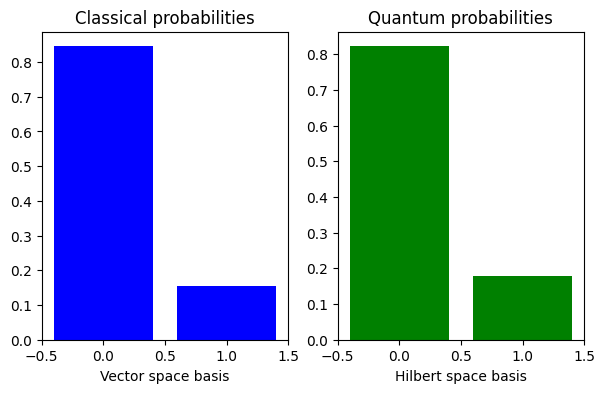

In [241]:
# Graphically visualize both distributions.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), probs_ancilla0_normalized, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

# References

1. Y. Zhou et al., "Quantum computing in power systems" in iEnergy, vol. 1, no. 2, pp. 170-187, June 2022, doi: 10.23919/IEN.2022.0021.
2. Brynjar Sævarsson et al, " Quantum Computing for Power Flow Algorithms: Testing on real Quantum Computers", arXiv:2204.14028
3. Harrow, A. W., Hassidim, A., & Lloyd, S. (2009). Quantum algorithm for linear systems of equations. Physical Review Letters, 103(15), 150502. https://doi.org/10.1103/PhysRevLett.103.150502
4. Ville Bergholm, Josephine Sullivan, et al. (2025, February 26). Solving systems of linear equations via HHL using Qrisp and Catalyst. PennyLane QML Demos. Retrieved from https://pennylane.ai/qml/demos/linear_equations_hhl_qrisp_catalyst